In [1]:
from bubblewrap import Bubblewrap
import numpy as np
from ava.models.vae import VAE,X_SHAPE
from ava.models.window_vae_dataset import get_window_partition, get_fixed_window_data_loaders
from ava.preprocessing.utils import get_spec
from ava.preprocessing.preprocess import tune_window_preprocessing_params,get_audio_filenames
import os
import glob
from scipy.io import wavfile

## Load data for VAE

In [2]:
dataPath = '/home/miles/isilon/All_Staff/birds/goldberg'
bird = 'Bird2CU22001'
conditions = ['*PBS*','*Drug*']
fullPath = os.path.join(dataPath,bird)
fullPaths = sum([glob.glob(os.path.join(fullPath,c)) for c in conditions],[])

wavs = [glob.glob(os.path.join(p,'*.wav')) for p in fullPaths]
times = [glob.glob(os.path.join(p,'*.time.txt')) for p in fullPaths]
for w,t in zip(wavs,times):
    w.sort()
    t.sort()

fs,_ = wavfile.read(wavs[0][0])

In [3]:
print(fullPaths)

['/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240527_Drug_t1', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240611_Drug_t2']


In [4]:
p = {
	'fs': fs,
	'get_spec': get_spec,
	'num_freq_bins': X_SHAPE[0],
	'num_time_bins': X_SHAPE[1],
	'nperseg': 512, # FFT
	'noverlap': 256, # FFT
	'max_dur': 0.1, # Big number
	'window_length': 0.01, #ms
	'min_freq': 400,
	'max_freq': 10e3,
	'spec_min_val': 1.3,
	'spec_max_val': 5.,
	'mel': True, # Frequency spacing
	'time_stretch': False,
	'within_syll_normalize': False,
	'real_preprocess_params': ('min_freq', 'max_freq', 'spec_min_val', \
			'spec_max_val'),
	'int_preprocess_params': tuple([]),
	'binary_preprocess_params': ('mel', 'within_syll_normalize'),
}

p = tune_window_preprocessing_params(fullPaths, p)
#afs = get_audio_filenames(fullPaths[0])
#afs = np.array(afs)
#file_index = np.random.randint(len(afs))
#audio_filename = afs[file_index]
#fs, audio = wavfile.read(audio_filename)
#duration = len(audio) / fs
#print(audio.shape)

Tune preprocessing parameters:


Set value for min_freq: [400]  
Set value for max_freq: [10000.0]  
Set value for spec_min_val: [1.3]  
Set value for spec_max_val: [5.0]  
Set value for mel: [T]  
Set value for within_syll_normalize: [F]  
Continue? [y] or [s]top tuning or [r]etune params:  s


In [11]:
def convert_txt_labels(roi_files,fs):

    new_files=[]

    for file in roi_files:
        try:
            on,off = np.loadtxt(file,delimiter=',',unpack=True)
            on,off = np.round(on/fs,4),np.round(off/fs,4)
            combined = np.stack([on,off]).T
            header = "Onsets/offsets for " + file
            seg_fn = file.split('.txt')[0] + 'combined.txt'
            np.savetxt(seg_fn, combined, fmt='%.5f', header=header)

            new_files.append(seg_fn)
        except:
            print(file)
            raise NotImplementedError
    return new_files

In [14]:
print(new_files)

['/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg1_20240610112205.timecombined.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg2_20240610112825.timecombined.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg3_20240610112842.timecombined.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg4_20240610113037.timecombined.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00009_seg5_20240610113833.timecombined.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00009_seg6_20240610114143.timecombined.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00013_seg7_20240610115049.timecombined.txt'

In [16]:
print(times[0])

['/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg1_20240610112205.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg2_20240610112825.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg3_20240610112842.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg4_20240610113037.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00009_seg5_20240610113833.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00009_seg6_20240610114143.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00013_seg7_20240610115049.time.txt', '/home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22

In [17]:
new_files = [convert_txt_labels(t,fs) for t in times]

In [5]:
partition = get_window_partition(fullPaths, fullPaths, 1,roi_suffix='.timecombined.txt')
partition['test'] = partition['train']
num_workers = min(7, os.cpu_count()-1)
loaders = get_fixed_window_data_loaders(partition, p, \
	num_workers=num_workers, batch_size=128,save_memory=False,min_spec_val=0.2)
loaders['test'] = loaders['train']

In [6]:
model = VAE(save_dir=f'/home/miles/Downloads/goldberg_budgie_data/{bird}_single_session_VAE_exclude_silence_10ms')

In [52]:
model.train_loop(loaders, epochs=2001, test_freq=100,save_freq=250,vis_freq=100)

Training: epochs 0 to 2000
Training set: 2048
Test set: 2048
Epoch: 0 Average loss: 71826.8420
Test loss: 5312.9543
Epoch: 1 Average loss: 13726.0319
Epoch: 2 Average loss: 5744.6222
Epoch: 3 Average loss: 3460.0363
Epoch: 4 Average loss: 2479.9313
Epoch: 5 Average loss: 1995.6588
Epoch: 6 Average loss: 1866.8355
Epoch: 7 Average loss: 1855.5010
Epoch: 8 Average loss: 1695.0824
Epoch: 9 Average loss: 1680.2181
Epoch: 10 Average loss: 1694.5015
Epoch: 11 Average loss: 1489.0866
Epoch: 12 Average loss: 1622.2892
Epoch: 13 Average loss: 1454.3900
Epoch: 14 Average loss: 1481.4460
Epoch: 15 Average loss: 1375.7889
Epoch: 16 Average loss: 1415.2583
Epoch: 17 Average loss: 1251.0370
Epoch: 18 Average loss: 1261.8071
Epoch: 19 Average loss: 1138.4147
Epoch: 20 Average loss: 1175.5450
Epoch: 21 Average loss: 1044.5788
Epoch: 22 Average loss: 1001.4562
Epoch: 23 Average loss: 934.2645
Epoch: 24 Average loss: 880.8836
Epoch: 25 Average loss: 825.0150
Epoch: 26 Average loss: 790.7039
Epoch: 27 Av

In [7]:
model.load_state(os.path.join(f'/home/miles/Downloads/goldberg_budgie_data/{bird}_single_session_VAE_exclude_silence_20ms','checkpoint_2000.tar'))

/hdd/miles/Bubblewrap_densities/ava/models/vae.py:469: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_location=self.device)


## To-do: 
- [x] embed vocalization as trajectories
- [x] fit bubblewrap
- [x] estimate fisher
- [x] estimate fisher on toy data

## Analysis

### embed full vocalizations

In [24]:
import torch
from tqdm import tqdm
p['embed_overlap'] = 0.
p['window_length'] = 0.02
shoulder=0.05
#def embed_voc(wav,roi,model):
    
def embed_vocalizations(model,parameters,partition):

    wavs,rois = partition['audio'],partition['rois']
    wavLats = []
    for w,r in tqdm(zip(wavs,rois),desc='embedding segments'):
        
        sr,aud = wavfile.read(w)
        aud = aud[:,0]
        ons,offs = np.loadtxt(r,unpack=True)
        #print(len(ons))
        #print(ons)
        #print(r)
        #print(w)
        #assert False
        for ii,(on,off) in enumerate(zip(ons,offs)):
            roiSpecs = []
            os = np.arange(on,off,(1 - parameters['embed_overlap'])*parameters['window_length'])
            fs = os + parameters['window_length']
            for o,f in zip(os,fs):
                target_times = np.linspace(o, f, \
    						parameters['num_time_bins'])
                #print(target_times.shape)
                #print(o.shape,f.shape)
                spec, flag = parameters['get_spec'](max(0.0, o-shoulder), \
						f+shoulder, aud, parameters, \
						fs=sr, target_times=target_times)
                if np.amax(spec) >= 0.01:
                    roiSpecs.append(spec)
                
            if len(roiSpecs) > 0:
                roiSpecs = np.stack(roiSpecs)
    
                lats,_,_ = model.encode(torch.from_numpy(roiSpecs).type(torch.FloatTensor).to(model.device))
                wavLats.append(lats.detach().cpu().numpy())
        
            else:
                print(f"removing {w} segment {ii}")

    #print(len(wavLats))

    #print("removed {} out of {} vocalizations")
    
    return wavLats

            
            


#### embed drug data

In [25]:
drug = ['*Drug*']
#fullPath = os.path.join(dataPath,bird)
drugPaths = sum([glob.glob(os.path.join(fullPath,c)) for c in drug],[])

wavs_drug = [glob.glob(os.path.join(p,'*.wav')) for p in drugPaths]

times_drug = [glob.glob(os.path.join(p,'*.timecombined.txt')) for p in drugPaths]
for w,t in zip(wavs_drug,times_drug):
    w.sort()
    t.sort()

In [26]:
os.listdir(fullPath)

['20240527_Drug_t1', '20240611_Drug_t2', '20240610_PBS_t2', '20240526_PBS_t1']

In [27]:
drug_lats = [np.vstack(embed_vocalizations(model,p,{'audio':wav,'rois':time})) for wav,time in zip(wavs_drug,times_drug)]

embedding segments: 5it [00:11,  2.31s/it]
embedding segments: 2it [00:05,  2.74s/it]

removing /home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240611_Drug_t2/Pair3CU22001CU54_warble_00030_seg3_20240611130731.wav segment 0
removing /home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240611_Drug_t2/Pair3CU22001CU54_warble_00030_seg3_20240611130731.wav segment 5


embedding segments: 6it [00:10,  1.17s/it]

removing /home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240611_Drug_t2/Pair3CU22001CU54_warble_00030_seg6_20240611131002.wav segment 19


embedding segments: 7it [00:10,  1.12it/s]

removing /home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240611_Drug_t2/Pair3CU22001CU54_warble_00030_seg8_20240611131027.wav segment 95


embedding segments: 9it [00:12,  1.13it/s]

removing /home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240611_Drug_t2/Pair3CU22001CU54_warble_00032_seg10_20240611131154.wav segment 40


embedding segments: 14it [00:27,  1.95s/it]


In [28]:
print(len(drug_lats))
for d in drug_lats:
    print(d.shape)

2
(8346, 32)
(19252, 32)


#### embed normal data

In [29]:
pbs = ['*PBS*']
#fullPath = os.path.join(dataPath,bird)
pbsPaths = sum([glob.glob(os.path.join(fullPath,c)) for c in pbs],[])

wavs_pbs = [glob.glob(os.path.join(p,'*.wav')) for p in pbsPaths]
times_pbs = [glob.glob(os.path.join(p,'*.timecombined.txt')) for p in pbsPaths]
for w,t in zip(wavs_pbs,times_pbs):
    w.sort()
    t.sort()

In [30]:
pb_lats = [np.vstack(embed_vocalizations(model,p,{'audio':wav,'rois':time})) for wav,time in zip(wavs_pbs,times_pbs)]

embedding segments: 0it [00:00, ?it/s]

removing /home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00006_seg1_20240610112205.wav segment 494


embedding segments: 14it [00:21,  1.49s/it]

removing /home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00037_seg15_20240610132508.wav segment 1099


embedding segments: 15it [00:36,  5.33s/it]

removing /home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00038_seg16_20240610133252.wav segment 156


embedding segments: 16it [00:40,  5.07s/it]

removing /home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240610_PBS_t2/Pair3CU22001CU54_warble_00038_seg16_20240610133252.wav segment 408


embedding segments: 18it [01:17,  4.32s/it]
embedding segments: 24it [00:58,  1.10s/it]

removing /home/miles/isilon/All_Staff/birds/goldberg/Bird2CU22001/20240526_PBS_t1/Pair3CU22001CU54_warble_00022_seg25_20240526125216.wav segment 101


embedding segments: 31it [01:08,  2.20s/it]


In [31]:
print(len(pb_lats))
for d in pb_lats:
    print(d.shape)

2
(55401, 32)
(47945, 32)


In [38]:
import time
start = time.time()
bws = [bubblewrap_data(p) for p in pb_lats]
bound_pbs = [bw.get_fisher_ub() for bw in bws]

print(np.round(time.time()-start,3))

45.987


In [39]:

bws_drug = [bubblewrap_data(d) for d in drug_lats]
bound_drug = [bw.get_fisher_ub() for bw in bws_drug]

In [40]:
print(bound_pbs)
print(bound_drug)

[Array(184721.88, dtype=float32), Array(131522.16, dtype=float32)]
[Array(56699.727, dtype=float32), Array(221530.84, dtype=float32)]


In [94]:
# is this really all the files? double triple check
print(len(partition['train']['audio']))

68


In [54]:
print(len(lats))

5693


## visualize

In [20]:
from bubblewrap import single_logB

from jax import jit, vmap
from jax import numpy as jnp
def single_B(x,mu,L,L_diag):
    n = mu.shape[0]
    B = jnp.exp(-(jnp.linalg.norm((x-mu)@L)**2) /2)/(2*jnp.pi)**(n/2) * jnp.exp(jnp.sum(L_diag))
    return B

B_jax = jit(vmap(single_B,in_axes=(None,0,0,0)))
def single_B_debug(x,mu,L,L_diag):
    n = mu.shape[0]
    norm = jnp.linalg.norm((x-mu)@L)**2
    denom = (2*jnp.pi)**(n/2)
    det = jnp.exp(jnp.sum(L_diag))
    B = jnp.exp(-norm/2)/denom * det
    return B,norm,denom,det
B_debug_jax = jit(vmap(single_B_debug,in_axes=(None,0,0,0)))

B_tmp_jax = jit(vmap(single_logB, in_axes=(None, 0, 0, 0)))

In [234]:
epsilon = 1e-14
logB_jax = jit(vmap(single_logB, in_axes=(None, 0, 0, 0)))
def get_fisher_perpoint(dataset,bw_model):

    precs = bw_model._get_precision()
    probs = np.vstack([np.exp(logB_jax(d,bw_model.mu,bw_model.L,bw_model.L_diag))*bw_model.alpha for d in dataset]).T
    
    assert np.sum(np.isnan(probs)) == 0, print(f"probabilities are nans!: {np.sum(np.isnan(probs))}")
    assert np.sum(np.isinf(probs)) == 0, print(f"probabilities are inf!: {np.sum(np.isinf(probs))}")
    
    
    print(np.sum(probs.sum(axis=0) == 0))
    
    probs = probs/(probs.sum(axis=0,keepdims=True) +epsilon)#np.log(probs) - np.log(probs.sum(axis=0,keepdims=True))
    
    #probs /= probs.sum(axis=0,keepdims=True)
    #assert False
    
    assert np.sum(np.isnan(probs)) == 0, print(f"normalized probabilities are nans!: {np.sum(np.isnan(probs))}")
    assert np.sum(np.isinf(probs)) == 0, print(f"normalized probabilities are inf!: {np.sum(np.isinf(probs))}")

    precs = precs.transpose(1,2,0) @ probs

    assert np.sum(np.isnan(precs)) == 0, print(f"weighted precisions contain nans!: {np.sum(np.isnan(precs))}")
    assert np.sum(np.isinf(precs)) == 0, print(f"weighted precisions contain infs!: {np.sum(np.isinf(precs))}")

    fishers = np.trace(precs)

    assert np.sum(np.isnan(fishers)) == 0, print(f"fisher vals contain nans!: {np.sum(np.isnan(fishers))}")
    assert np.sum(np.isinf(fishers)) == 0, print(f"fisher vals contain infs!: {np.sum(np.isinf(fishers))}")
    
    return fishers

In [235]:
fishers_drug_pbs = np.hstack([get_fisher_perpoint(ds,bws) for ds in drug_lats])
fishers_pbs_pbs = np.hstack([get_fisher_perpoint(ds,bws) for ds in pb_lats])

5
33
58
42


In [236]:
fishers_drug_drug = np.hstack([get_fisher_perpoint(ds,bws_drug) for ds in drug_lats])
fishers_pbs_drug = np.hstack([get_fisher_perpoint(ds,bws_drug) for ds in pb_lats])

3
9
32
19


In [239]:
fishers_pbs = np.hstack([fishers_drug_pbs,fishers_pbs_pbs])
fishers_drug = np.hstack([fishers_drug_drug,fishers_pbs_drug])

In [54]:
print(bws.alpha.shape,bws.A.shape,bws.B.shape)
test_prob = B_jax(drug_lats[0][0], bws.mu,bws.L,bws.L_diag)*bws.alpha

# update to take fisher of each distribution???
precs_pbs = bws._get_precision()#.transpose(2,1,0)[None,...]
precs_drug = bws_drug._get_precision()#.transpose(2,1,0)[None,...]

drug_probs_pbs = np.vstack([B_jax(dg,bws.mu,bws.L,bws.L_diag)*bws.alpha for dg in np.vstack(drug_lats)]) # these might just need to be alphas? need to update this part and all below. and also fit to each dataset independently!!
pbs_probs_pbs = np.vstack([B_jax(p,bws.mu,bws.L,bws.L_diag)*bws.alpha for p in np.vstack(pb_lats)])
drug_probs_drug = np.vstack([B_jax(dg,bws_drug.mu,bws_drug.L,bws_drug.L_diag)*bws_drug.alpha for dg in np.vstack(drug_lats)])
pbs_probs_drug = np.vstack([B_jax(p,bws_drug.mu,bws_drug.L,bws_drug.L_diag)*bws_drug.alpha for p in np.vstack(pb_lats)])

(1000,) (1000, 1000) (1000,)


In [55]:
all_pbs = np.vstack([drug_probs_pbs,pbs_probs_pbs]).T
all_drug = np.vstack([drug_probs_drug,pbs_probs_drug]).T
precs_pbs = bws._get_precision()#.transpose(2,1,0)[None,...]
precs_drug = bws_drug._get_precision()#.transpose(2,1,0)[None,...]
print(all_drug.shape)
print(all_pbs.shape)
print(precs_pbs.shape)
print(precs_drug.shape)

precs_pbs = precs_pbs.transpose(1,2,0) @ all_pbs
precs_drug = precs_drug.transpose(1,2,0)@all_drug
print(precs_pbs.shape)
print(precs_drug.shape)
fishers_pbs,fishers_drug = np.trace(precs_pbs),np.trace(precs_drug)

(1000, 130944)
(1000, 130944)
(1000, 32, 32)
(1000, 32, 32)
(32, 32, 130944)
(32, 32, 130944)


In [185]:
colors = np.log(fishers_pbs/fishers_drug)
valid_inds = np.argwhere(1- np.isnan(colors))

print(len(valid_inds)/len(colors))

0.9590791168181564


/tmp/ipykernel_9555/2920642178.py:1: RuntimeWarning: invalid value encountered in divide
  colors = np.log(fishers_pbs/fishers_drug)


In [243]:
import umap #import UMAP

all_lats = np.vstack([np.vstack(drug_lats),np.vstack(pb_lats)])
print(all_lats.shape)
um = umap.UMAP(n_components=2,n_neighbors=15)
uml = um.fit_transform(all_lats)

(259536, 32)


In [47]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(np.vstack([np.vstack(drug_lats),np.vstack(pb_lats)]))

PCA()

In [279]:
pbs_projs,drug_projs = pca.transform(pb_lats[0]),pca.transform(drug_lats[0])
all_projs = np.vstack([drug_projs,pbs_projs])

(259536,)
(259536, 2)


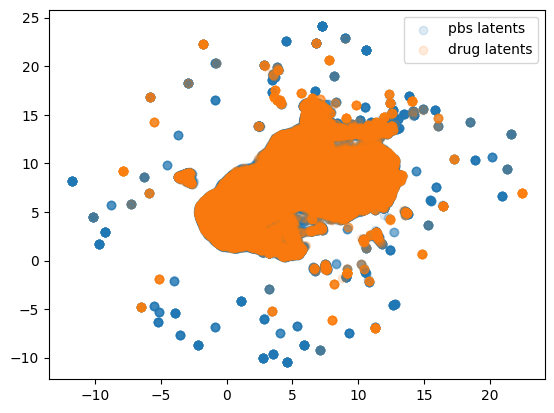

"\ncm = sns.color_palette('crest_r',as_cmap=True)\nax = plt.gca()\n\ng = ax.scatter(uml[valid_inds,0],uml[valid_inds,1],c=colors[valid_inds],cmap=cm)#label='pbs latents',alpha=0.2)\nplt.colorbar(g,ax=ax)\n#ax.scatter(uml[inds==1,0],uml[inds==1,1],color='tab:orange',label='drug latents',alpha=0.2)\nplt.show()\nplt.close()\n"

In [244]:
#!pip install seaborn
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns
inds = np.hstack([np.ones((np.vstack(drug_lats).shape[0],)),2*np.ones((np.vstack(pb_lats).shape[0],))])
print(inds.shape)
print(uml.shape)
ax = plt.gca()

ax.scatter(uml[inds==2,0],uml[inds==2,1],color='tab:blue',label='pbs latents',alpha=0.15)

ax.scatter(uml[inds==1,0],uml[inds==1,1],color='tab:orange',label='drug latents',alpha=0.15)
plt.legend()
plt.show()
plt.close()

"""
cm = sns.color_palette('crest_r',as_cmap=True)
ax = plt.gca()

g = ax.scatter(uml[valid_inds,0],uml[valid_inds,1],c=colors[valid_inds],cmap=cm)#label='pbs latents',alpha=0.2)
plt.colorbar(g,ax=ax)
#ax.scatter(uml[inds==1,0],uml[inds==1,1],color='tab:orange',label='drug latents',alpha=0.2)
plt.show()
plt.close()
"""

[246366.5      232425.203125 250847.9375   ... 212741.015625 244960.421875
 248340.734375]


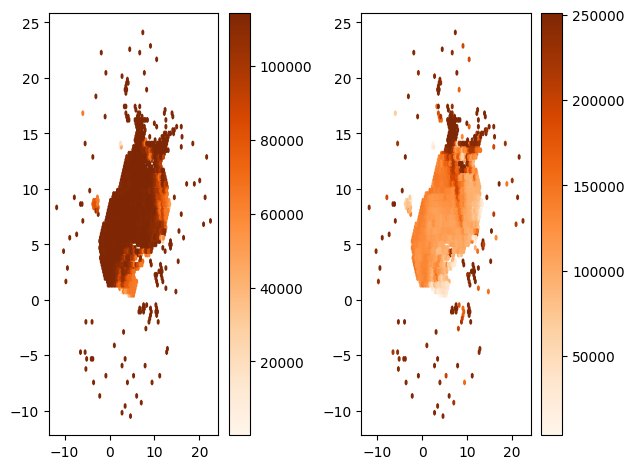

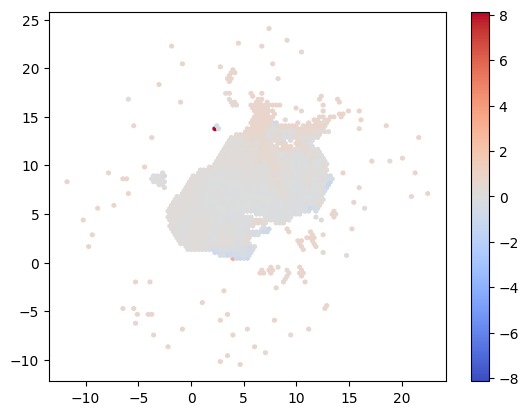

In [245]:
from matplotlib.colors import Normalize
fig = plt.figure()
ax = fig.add_subplot(121)
ax2= fig.add_subplot(122)
hb_pbs = ax.hexbin(uml[:,0].squeeze(),uml[:,1].squeeze(),C=fishers_pbs,cmap='Oranges',reduce_C_function=np.mean,gridsize=100)
hb_drug = ax2.hexbin(uml[:,0].squeeze(),uml[:,1].squeeze(),C=fishers_drug,cmap='Oranges',reduce_C_function=np.mean,gridsize=100)
pbs_local_means = hb_pbs.get_array()
drug_local_means = hb_drug.get_array()
print(drug_local_means)
ratios = np.log(drug_local_means/pbs_local_means)
offsets = hb_pbs.get_offsets()

cb = fig.colorbar(hb_pbs,ax=ax)
cb2 = fig.colorbar(hb_drug,ax=ax2)
plt.tight_layout()
plt.show()
plt.close()

max_val = np.amax(np.abs(ratios))
norm = Normalize(vmin=-max_val,vmax=max_val)
fig = plt.figure()
ax = plt.gca()

hb_ratios = ax.hexbin(offsets[:,0],offsets[:,1],C=ratios,cmap='coolwarm',norm=norm)
cb = fig.colorbar(hb_ratios,ax=ax)
plt.show()
plt.close()
#ax.scatter(uml[inds==1,0],uml[inds==1,1],color='tab:orange',label='drug latents',alpha=0.15)

### Fit bubblewrap

In [37]:

def bubblewrap_data(data):
    
    N = 1000             # number of nodes to tile with
    lam = 1e-3          # lambda 
    nu = 1e-3           # nu
    eps = 1e-3          # epsilon sets data forgetting
    step = 8e-2         # for adam gradients
    
    B_thresh = -10      # threshold for when to teleport (log scale)    
    batch = True       # run in batch mode 
    
    go_fast = True     # flag to skip computing priors, predictions, and entropy for optimal speed
    future_distance = 1

    T = data.shape[0]      
    d = data.shape[1]       # should be 32

    M = 50           # small set of data seen for initialization
    batch_size = T//100      # batch mode size; if not batch is 1
    
    bw = Bubblewrap(N, d, step=step, lam=lam, M=M, eps=eps, nu=nu, B_thresh=B_thresh, batch=batch, batch_size=batch_size, go_fast=go_fast, future_distance=future_distance)

    #print('initializing bubblewrap...')
    order = np.random.choice(len(data),len(data),replace=False)
    
    step = batch_size
    for i in np.arange(0, M, step): 
        bw.observe(data[order[i:i+step]])
    bw.init_nodes()
    #print(f"{np.sum(np.isnan(bw.L))} nan values in L")
    init = -M
    end = T-M
    step = batch_size

    #print('fitting bubblewrap....')
    for i in np.arange(init, end, step): #,desc='fitting bubblewrap....'):
        order = np.random.choice(len(data),len(data),replace=False)

        future_index = i+M+step - 2 + bw.future_distance
        future_x = data[order[future_index]] if future_index < ((end- 1) + M ) else None
    
        bw.observe(data[order[i+M:i+M+step]], future_x=future_x)
        bw.e_step()  
        bw.grad_Q()
        nNan = np.sum(np.isnan(bw.L))
        if nNan > 0:
            print(f"after iter {i+1}, {nNan} nans in L")

    return bw

def update_bubblewrap(bw,data):

    T = data.shape[0]      
    d = data.shape[1]
    M = T//100              # small set of data seen for initialization
    batch_size = T//100      # batch mode size; if not batch is 1

    init = -M
    end = T-M
    step = batch_size

    #print('fitting bubblewrap....')
    for i in np.arange(init, end, step): #,desc='fitting bubblewrap....'):
        future_index = i+M+step - 2 + bw.future_distance
        future_x = data[future_index] if future_index < ((end- 1) + M ) else None
    
        bw.observe(data[i+M:i+M+step], future_x=future_x)
        bw.e_step()  
        bw.grad_Q(mode='update')
        nNan = np.sum(np.isnan(bw.L))
        if nNan > 0:
            print(f"after iter {i+1}, {nNan} nans in L")

    return bw
    

    

In [ ]:
bw = bubblewrap_data(lats)
bubble_bound = bw.get_fisher_ub()